# Topic distribution

Using the bag of words generated from the corpus, and the topic models generated, I now use them to project publications in the LDA topic space, as well as for the individuals in the School

## Setup

In [14]:
import pandas as pd
import numpy as np
import cPickle as pkl

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
rng = np.random.RandomState(1234567)

In [2]:
from gensim import models
from gensim.corpora import Dictionary

In [3]:
lookup_pub = pkl.load(open('../infnet-analysis/data/lookup_pub.pkl', 'rb'))
lookup_poinf = pkl.load(open('../infnet-analysis/data/lookup_poinf.pkl','rb'))
pub_toks = pkl.load(open('../infnet-scrapper/data/pub_toks.pkl','rb'))

In [5]:
from hdbscan import HDBSCAN ## TRYING WITH HDBSCAN:  http://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

# Topic Distribution by Publications

In [6]:
# Load Dictionary to convert words to id:
dictionary = pkl.load(open('../topicModel/dictionary.pkl','rb'))

In [7]:
# Convert tokens to bow:
bowified = lambda row: dictionary.doc2bow(row.summary_toks)
pub_toks['bow'] = pub_toks.apply(bowified, axis=1)

In [9]:
pub_toks.head(4)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  1994   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  2012   

                                                                           summary_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [balloon, stabil, analysi, jet, hmode, dischar...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [queri, process, data, integr, chapter, illust...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehens, syntax, syntax, comprehens, close...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [evalu, speaker, verif, secur, detect, hmmbase...   

                                                                                    bow  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab  [(40, 2), (156, 1), (223, 2), (293, 2), (328, ...  
18b1a861-afef-4fff-bc80-d02e05be18c4  [(40, 1), (229, 1), (253, 1), (319, 2), (330, ...  
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [(90, 3), (123, 1), (186, 1), (189, 5), (196, ...  
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [(18, 1), (28, 1), (29, 2), (30, 1), (63, 1), ...

In [8]:
# load the LDA models:
fullpubLDA = models.LdaModel.load('fullpub.ldamodel')

In [9]:
def inference(ldaModel, ldaVector):
    num_topics = ldaModel.num_topics
    topic_dist = ldaModel[ldaVector]
    
    # index the topic_distribution according to the distribution:
    out = [0]*num_topics
    for (i,v) in topic_dist:
        out[i] = v
    assert len(out) == num_topics
    return out

In [10]:
_inference = lambda row: inference(fullpubLDA, row.bow)
pub_toks['topic_distribution'] = pub_toks.apply(_inference, axis=1)

In [15]:
pub_toks.head(4)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  1994   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  2012   

                                                                           summary_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [balloon, stabil, analysi, jet, hmode, dischar...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [queri, process, data, integr, chapter, illust...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehens, syntax, syntax, comprehens, close...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [evalu, speaker, verif, secur, detect, hmmbase...   

                                                                                    bow  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [(40, 2), (156, 1), (223, 2), (293, 2), (328, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [(40, 1), (229, 1), (253, 1), (319, 2), (330, ...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [(90, 3), (123, 1), (186, 1), (189, 5), (196, ...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [(18, 1), (28, 1), (29, 2), (30, 1), (63, 1), ...   

                                                                     topic_distribution  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab  [0, 0.0982922003593, 0, 0.0248418858752, 0.422...  
18b1a861-afef-4fff-bc80-d02e05be18c4  [0, 0, 0, 0, 0, 0.153429075164, 0, 0, 0.341365...  
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [0, 0.298135265913, 0, 0, 0, 0, 0, 0, 0, 0.181...  
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [0, 0, 0, 0, 0.132472201269, 0, 0, 0, 0.122855...

In [11]:
def best_topic(topic_dist):
    """
    Assign the pulbication with the topic that best describes it;
    this is equivalent to the index that have the highest topic_distribution
    """
    a = np.argmax(topic_dist)
    assert a < 20
    assert a >= 0
    return a

In [15]:
pub_toks['best_topic'] = pub_toks.apply(lambda row: best_topic(row.topic_distribution), axis=1)

In [92]:
pub_toks.head(4)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  1994   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  2012   

                                                                           summary_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [balloon, stabil, analysi, jet, hmode, dischar...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [queri, process, data, integr, chapter, illust...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehens, syntax, syntax, comprehens, close...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [evalu, speaker, verif, secur, detect, hmmbase...   

                                                                                    bow  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [(40, 2), (156, 1), (223, 2), (293, 2), (328, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [(40, 1), (229, 1), (253, 1), (319, 2), (330, ...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [(90, 3), (123, 1), (186, 1), (189, 5), (196, ...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [(18, 1), (28, 1), (29, 2), (30, 1), (63, 1), ...   

                                                                     topic_distribution  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [0, 0.0982922003593, 0, 0.0248418858752, 0.422...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [0, 0, 0, 0, 0, 0.153429075164, 0, 0, 0.341365...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [0, 0.298135265913, 0, 0, 0, 0, 0, 0, 0, 0.181...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [0, 0, 0, 0, 0.132472201269, 0, 0, 0, 0.122855...   

                                      best_topic  
pub_id                                            
400818dc-63af-4a26-80c5-906f98e1f8ab           4  
18b1a861-afef-4fff-bc80-d02e05be18c4          18  
309fdbfc-227b-4588-9264-f0f4e3cadfcb          18  
d5814bab-5fc2-4c31-92b7-543c7ce75cb4          13

## Clustering

In [16]:
## Our dataset will be the topic_distribution:
data = pub_toks.topic_distribution.values

### Visualisation

We can visualise the data in 2D, and color each publication based on the most salient topic it is on:

In [ ]:
from sklearn import manifold

#### `TSNE`

Here, use the `manifold` package from sklearn to reduce the dimensionality of the data for visualisation.
For coloring, use the topic that gives the highest probability

In [27]:
x_components = manifold.TSNE(n_components=2, init='pca', random_state=rng).fit_transform(data)

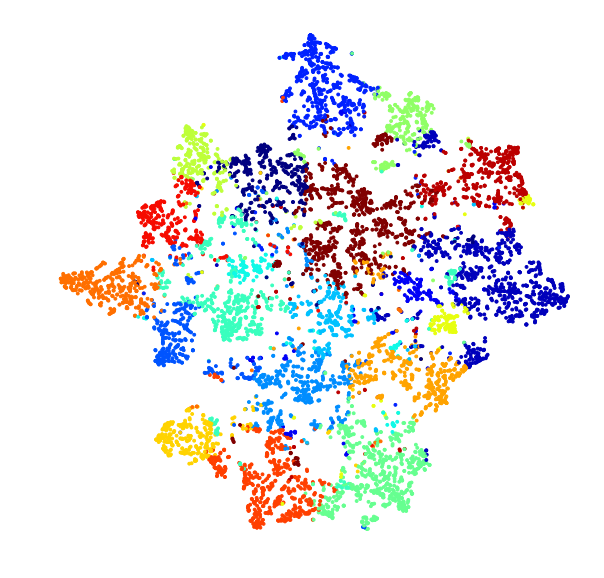

In [103]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
plt.show()

#### `MDS`

In [218]:
# Multidimensional Scaling
mds_components = manifold.MDS(n_components=2, random_state=rng).fit_transform(data)

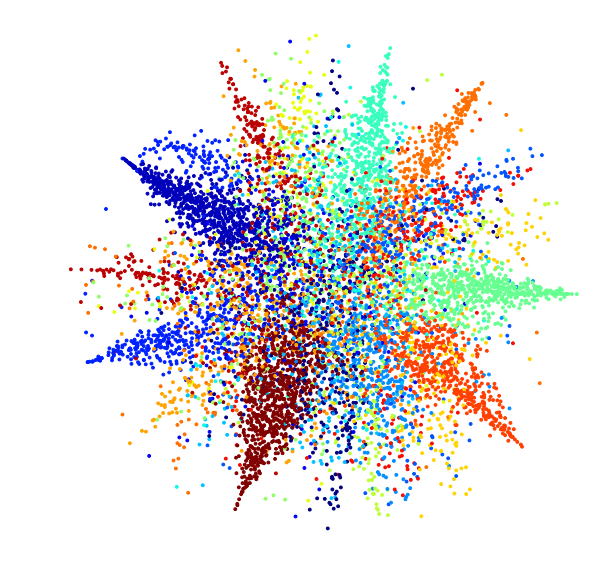

In [219]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.scatter(mds_components[:,0], mds_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
plt.show()

While the colors of the publications are based on the topic the publication is salient on (from the LDA), we make no assumption that these are the clusters that are being used. 

Hence, now we use some clustering algorithm to cluster our data such that we can color them accordingly. In our clustering algorithms, we have 20 clusters as well, similar to the topics.

### KMeans

In [25]:
from sklearn.cluster import KMeans

####  `n_cluster = 20`

In [26]:
kmeansClustering = KMeans(n_clusters=20).fit_predict(data)

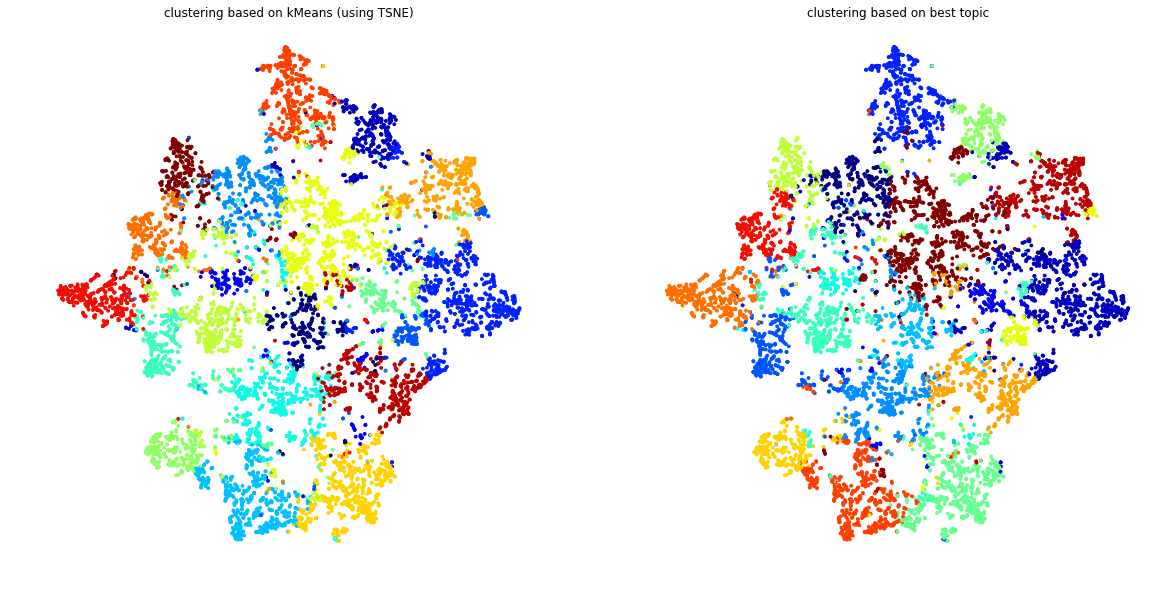

In [28]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(x_components[:,0], x_components[:,1], c=kmeansClustering, cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on kMeans (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=8)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

In [ ]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(mds_components[:,0], mds_components[:,1], c=kmeansClustering, cmap=plt.cm.jet, s=20)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('Clustering baed on kMeans (mds)')

ax2 = f.add_subplot(122)
ax2.scatter(mds_components[:,0], mds_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=20)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('Clustering based on best_topic (mds)')
plt.show()
plt.show()

#### `n_cluster = 30`

In [29]:
kmeansClustering30 = KMeans(n_clusters=30).fit_predict(data)

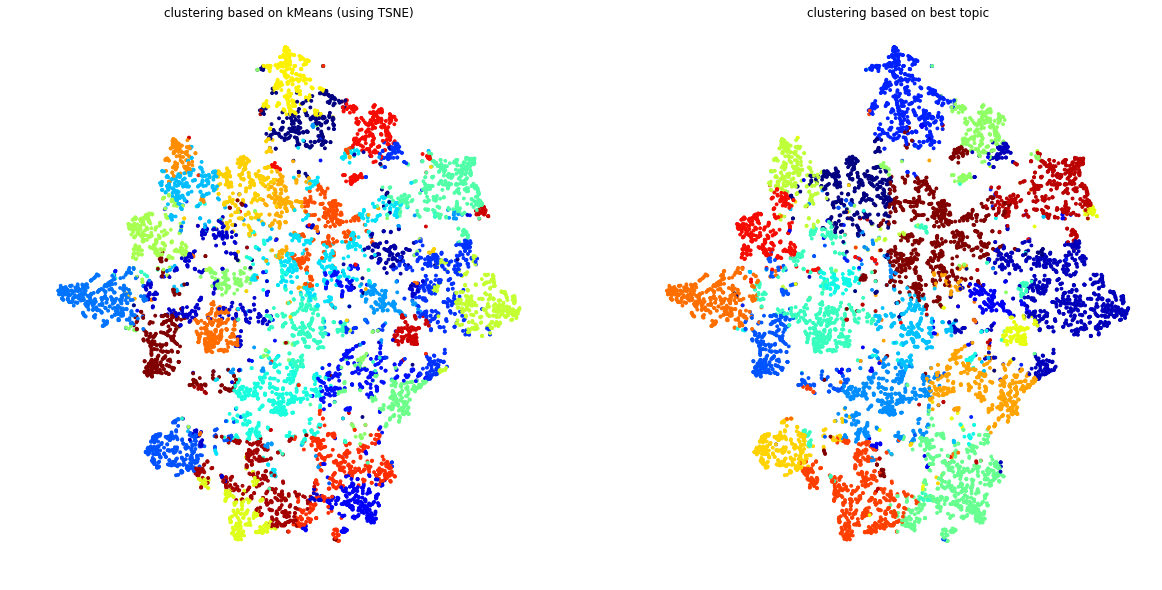

In [30]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(x_components[:,0], x_components[:,1], c=kmeansClustering30, cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on kMeans (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=8)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

#### `n_cluster = 10`

In [33]:
kmeansClustering10 = KMeans(n_clusters=10).fit_predict(data)

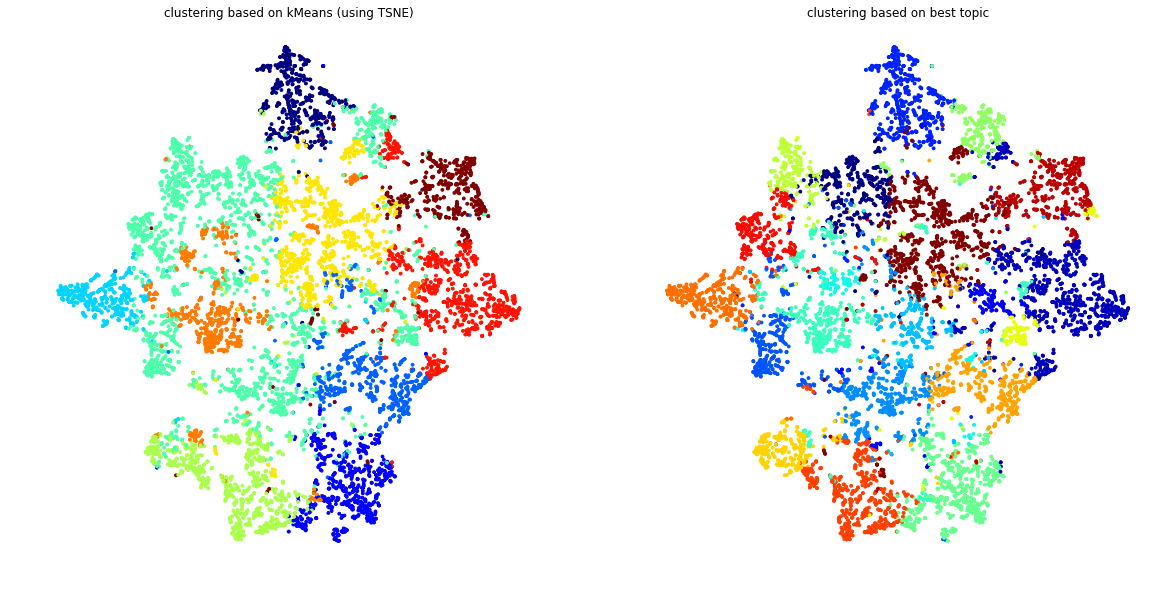

In [34]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(x_components[:,0], x_components[:,1], c=kmeansClustering10, cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on kMeans (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=8)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

### DBScan

In [63]:
from sklearn.cluster import DBSCAN

In [62]:
dbscan_pub = DBSCAN().fit(data)

In [64]:
dbscan_clusters = dbscan_pub.labels_
n_clusters_ = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
print 'number of clusters:', n_clusters_

number of clusters: 1


In [65]:
dbscan_pub = DBSCAN().fit(x_components)

In [66]:
dbscan_clusters = dbscan_pub.labels_
n_clusters_ = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
print 'number of clusters:', n_clusters_

number of clusters: 203


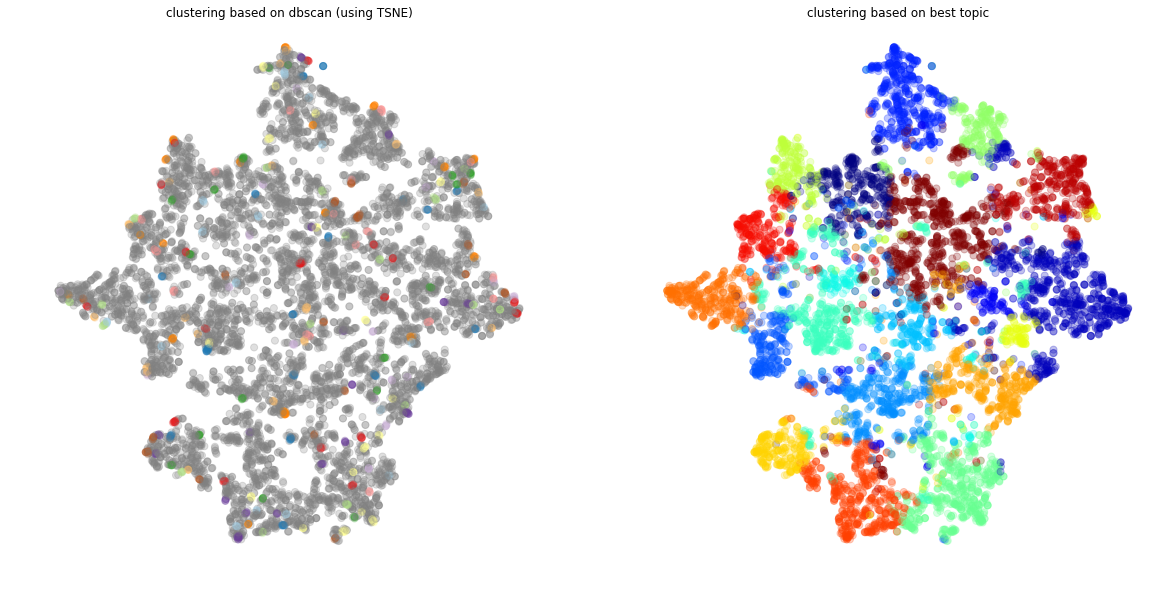

In [107]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
color_palette = sns.color_palette('Paired', 203)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in dbscan_clusters]
ax.scatter(x_components[:,0], x_components[:,1], c=cluster_colors, s=50, alpha=.25)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on dbscan (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=50, alpha=.25)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

In [220]:
dbscan_pub_mds = DBSCAN().fit(mds_components)

In [221]:
dbscan_pub_mds_clusters = dbscan_pub_mds.labels_
n_clusters_ = len(set(dbscan_pub_mds_clusters)) - (1 if -1 in dbscan_pub_mds_clusters else 0)
print 'number of clusters:', n_clusters_

number of clusters: 1


### HDBSCAN

In [83]:
from hdbscan import HDBSCAN
import hdbscan

In [41]:
hdbscan_cluster = HDBSCAN().fit(data)

In [44]:
n_clusters_ = len(set(hdbscan_cluster.labels_)) - (1 if -1 in hdbscan_cluster.labels_ else 0)
print 'number of clusters:', n_clusters_

number of clusters: 102


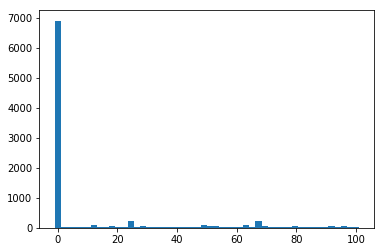

In [60]:
f = plt.figure()
ax = f.add_subplot(111)
ax.hist(hdbscan_cluster.labels_,bins=50);
plt.show()

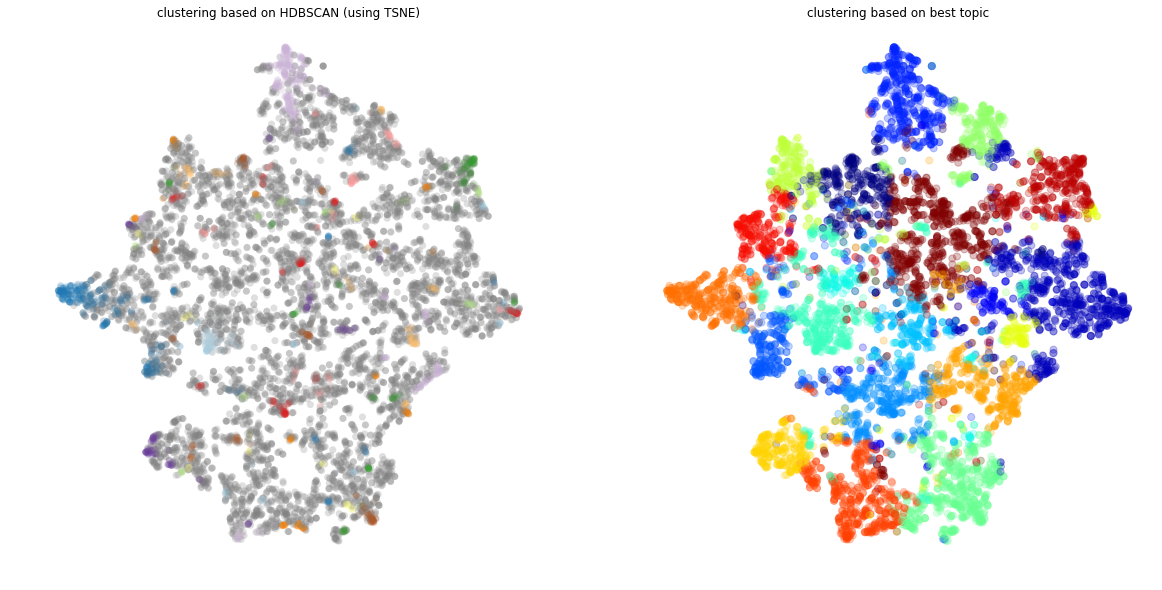

In [108]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
color_palette = sns.color_palette('Paired', 103)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in hdbscan_cluster.labels_]
#  colors weighted according to te probability of being in the cluster
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, hdbscan_cluster.probabilities_)] 
ax.scatter(*x_components.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

# ax.scatter(x_components[:,0], x_components[:,1], c=hdbscan_cluster.labels_, cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on HDBSCAN (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=50, alpha=.25)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

### Soft clustering in HDBSCAN*

In [78]:
clusterer = HDBSCAN(prediction_data=True).fit(data)

In [79]:
n_clusters_ = len(set(hdbscan_cluster.labels_)) - (1 if -1 in hdbscan_cluster.labels_ else 0)
print 'number of clusters:', n_clusters_

number of clusters: 102


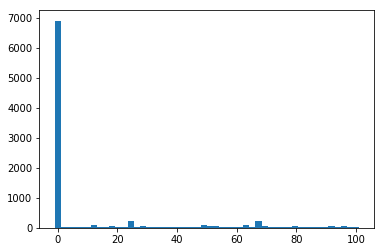

In [81]:
f = plt.figure()
ax = f.add_subplot(111)
ax.hist(clusterer.labels_,bins=50);
plt.show()

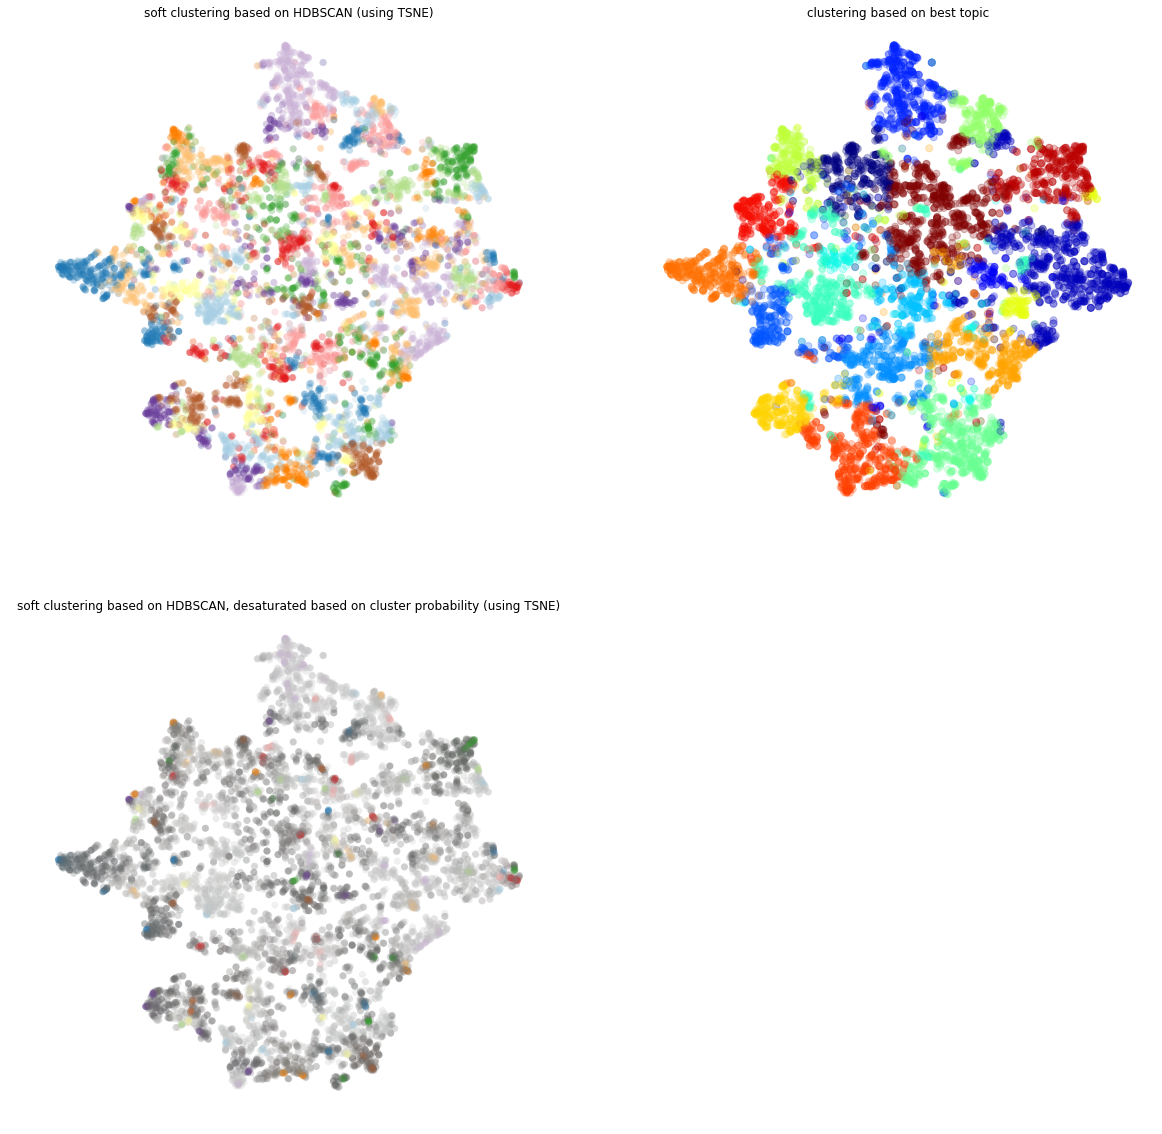

In [109]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(221)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 102)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
ax.scatter(*x_components.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

# ax.scatter(x_components[:,0], x_components[:,1], c=hdbscan_cluster.labels_, cmap=plt.cm.jet, s=8)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('soft clustering based on HDBSCAN (using TSNE)')
ax2 = f.add_subplot(222)
ax2.scatter(x_components[:,0], x_components[:,1], c=list(pub_toks.best_topic), cmap=plt.cm.jet, s=50, alpha=.25)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')

ax3 = f.add_subplot(223)
cluster_colors = [sns.desaturate(color_palette[np.argmax(x)], np.max(x))
                  for x in soft_clusters]
ax3.scatter(*x_components.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)
ax3.axis('off')
ax3.set_title('soft clustering based on HDBSCAN, desaturated based on cluster probability (using TSNE)')
plt.show()

# Topic Distribution of PoInf

In [92]:
# Create a new pandas table that merge the lookup_poinf and lookup_pub
# each pub in lookup_pub have a collab_id that have a list of collaborators by id
# We can ignore those that are not in the list of id for PoInf

# Create the list of ids for easy checking:
poinf_id = set(lookup_poinf.index)

# we can now create such an index:
pub_mapping = {str(_id):set() for _id in list(poinf_id)}

for row in lookup_pub.iterrows():
    pub_id = row[0]
    collab_ids = row[1]['collab_id']
    for _id in collab_ids:
        if _id in poinf_id:
            pub_mapping[_id].add(pub_id)

In [93]:
row_list = [{'id':k, 'pub_ids':v} for (k,v) in pub_mapping.items()]

In [94]:
# Add these pub_ids to the pandas df:
df_pubmapping = pd.DataFrame(row_list)

In [95]:
lookup_poinf_more = lookup_poinf.join(df_pubmapping.set_index('id'))

In [37]:
lookup_poinf_more.iloc[20:24]

last_name first_name  \
id                                                            
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931     steuwer     michel   
102286ee-5f21-4aed-abfd-e4ea1a615223  oberlander        jon   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7         wen     zhenyu   
114a78ef-c940-4653-8429-7c2897a96043   jovanovic     jelena   

                                                                          perseonal_url  \
id                                                                                        
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931  http://www.research.ed.ac.uk/portal/en/persons...   
102286ee-5f21-4aed-abfd-e4ea1a615223  http://www.research.ed.ac.uk/portal/en/persons...   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7  http://www.research.ed.ac.uk/portal/en/persons...   
114a78ef-c940-4653-8429-7c2897a96043  http://www.research.ed.ac.uk/portal/en/persons...   

                                                      position  \
id                                                               
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931                   unknown   
102286ee-5f21-4aed-abfd-e4ea1a615223                 professor   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7        research associate   
114a78ef-c940-4653-8429-7c2897a96043  visitor official visitor   

                                                                            parent  \
id                                                                                   
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931  institute for computing systems architecture   
102286ee-5f21-4aed-abfd-e4ea1a615223                         school of informatics   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7                         school of informatics   
114a78ef-c940-4653-8429-7c2897a96043                         school of informatics   

                                                                            institute  \
id                                                                                      
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931   laboratory for foundations of computer science   
102286ee-5f21-4aed-abfd-e4ea1a615223  institute of language cognition and computation   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7   laboratory for foundations of computer science   
114a78ef-c940-4653-8429-7c2897a96043  institute of language cognition and computation   

                                             full_name  institute_class  \
id                                                                        
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931    steuwer michel                3   
102286ee-5f21-4aed-abfd-e4ea1a615223    oberlander jon                2   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7        wen zhenyu                3   
114a78ef-c940-4653-8429-7c2897a96043  jovanovic jelena                2   

                                               alias  \
id                                                     
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931     steuwer, m.   
102286ee-5f21-4aed-abfd-e4ea1a615223  oberlander, j.   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7         wen, z.   
114a78ef-c940-4653-8429-7c2897a96043   jovanovic, j.   

                                                                                pub_ids  \
id                                                                                        
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931  {20cb2fdd-6d93-40b9-9cab-e9d818eb166e, b74a3be...   
102286ee-5f21-4aed-abfd-e4ea1a615223  {5be3a6b1-5ee4-4a39-9fff-88b22238fb98, 4629e88...   
10ff8e7a-53b2-4d2f-adad-ef695bc595a7  {872e450f-87e9-4956-9678-5b09f3cd4f84, a4cad99...   
114a78ef-c940-4653-8429-7c2897a96043             {b4b0b45d-72d9-4f39-929c-ea451288f253}   

                                                                                   toks  
id                                                                                       
0ed800f5-a3a0-47d7-a8b3-f97a4f2b6931  [[highlevel, program, medic, imag, multigpu, s...  
102286ee-5f21-4aed-abfd-e4ea1a615223  [[verbal, effect, vis

In [96]:
def getToks(pub_ids):
    out = []
    try:
        if len(pub_ids):
            for pub_id in pub_ids:
                out.extend(pub_toks[pub_toks.index == pub_id].summary_toks)
            # Convert the list of lists to a single list:
            out = [tok for tokList in out for tok in tokList]
    except TypeError:
        print(pub_ids)
        
    return out

In [97]:
lookup_poinf_more['summary_toks'] = lookup_poinf_more.apply(lambda row: getToks(row.pub_ids), axis=1)

nan
nan
nan
nan


In [98]:
# Conert to BOW using bowified:
lookup_poinf_more['bow'] = lookup_poinf_more.apply(bowified, axis=1)

In [99]:
lookup_poinf_more['topic_distribution'] = lookup_poinf_more.apply(_inference, axis=1)

In [51]:
lookup_poinf_more.head(2)

last_name first_name  \
id                                                          
003ec9bb-18aa-4e6e-95e9-359f0968262a      gray      gavin   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706   jackson       paul   

                                                                          perseonal_url  \
id                                                                                        
003ec9bb-18aa-4e6e-95e9-359f0968262a  http://www.research.ed.ac.uk/portal/en/persons...   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  http://www.research.ed.ac.uk/portal/en/persons...   

                                                position  \
id                                                         
003ec9bb-18aa-4e6e-95e9-359f0968262a  research assistant   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706     senior lecturer   

                                                     parent  \
id                                                            
003ec9bb-18aa-4e6e-95e9-359f0968262a  school of informatics   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  school of informatics   

                                                                         institute  \
id                                                                                   
003ec9bb-18aa-4e6e-95e9-359f0968262a  institute for computing systems architecture   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  institute for computing systems architecture   

                                         full_name  institute_class  \
id                                                                    
003ec9bb-18aa-4e6e-95e9-359f0968262a    gray gavin                5   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  jackson paul                5   

                                                           alias  \
id                                                                 
003ec9bb-18aa-4e6e-95e9-359f0968262a                         NaN   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  jackson, p. b.|jackson, p.   

                                                                                pub_ids  \
id                                                                                        
003ec9bb-18aa-4e6e-95e9-359f0968262a                                                 {}   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  {c5754b06-fcf9-4362-aa3a-1142589b5402, 167c4b6...   

                                                                                   toks  \
id                                                                                        
003ec9bb-18aa-4e6e-95e9-359f0968262a                                                 []   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [nuprl, use, circuit, design, nuprl, interact,...   

                                                                           summary_toks  \
id                                                                                        
003ec9bb-18aa-4e6e-95e9-359f0968262a                                                 []   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [nuprl, use, circuit, design, nuprl, interact,...   

                                                                                    bow  \
id                                                                                        
003ec9bb-18aa-4e6e-95e9-359f0968262a                                                 []   
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [(22, 2), (27, 1), (29, 15), (39, 1), (40, 1),...   

                                                                     topic_distribution  
id                                                                                       
003ec9bb-18aa-4e6e-95e9-359f0968262a  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...  
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [0, 0.326083956289, 0.120584281776, 0.05047796...

In [100]:
len(lookup_poinf_more)

296

In [101]:
lookup_poinf_more['remove_drop'] = lookup_poinf_more.apply(lambda row: len(row.bow) == 0, axis=1)

In [102]:
# Remove individuals that does not have any bow:
lookup_poinf_more_drop = lookup_poinf_more.drop(lookup_poinf_more[lookup_poinf_more.remove_drop==True].index)

In [103]:
len(lookup_poinf_more_drop)

219

In [104]:
lookup_poinf_more_drop['best_topic'] = lookup_poinf_more_drop.apply(lambda row: best_topic(row.topic_distribution), axis=1)

/Users/weiting/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [154]:
lookup_poinf_more_drop.head(2)

last_name first_name  \
id                                                          
010f9bf0-c04c-4cfb-ab3d-ca150de1e706   jackson       paul   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84    franke     bjoern   

                                                                          perseonal_url  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  http://www.research.ed.ac.uk/portal/en/persons...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  http://www.research.ed.ac.uk/portal/en/persons...   

                                             position                 parent  \
id                                                                             
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  senior lecturer  school of informatics   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84           reader  school of informatics   

                                                                            institute  \
id                                                                                      
010f9bf0-c04c-4cfb-ab3d-ca150de1e706     institute for computing systems architecture   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  institute of language cognition and computation   

                                          full_name  institute_class  \
id                                                                     
010f9bf0-c04c-4cfb-ab3d-ca150de1e706   jackson paul                5   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  franke bjoern                2   

                                                           alias  \
id                                                                 
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  jackson, p. b.|jackson, p.   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84                  franke, b.   

                                                                                pub_ids  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  {c5754b06-fcf9-4362-aa3a-1142589b5402, 167c4b6...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  {9a3368cc-e69d-4ecf-bad1-b43ab0ac89a8, ab3fccd...   

                                                                                   toks  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [nuprl, use, circuit, design, nuprl, interact,...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  [use, genet, program, sourcelevel, data, assig...   

                                                                           summary_toks  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [nuprl, use, circuit, design, nuprl, interact,...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  [use, genet, program, sourcelevel, data, assig...   

                                                                                    bow  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [(22, 2), (27, 1), (29, 15), (39, 1), (40, 1),...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  [(1, 1), (3, 5), (6, 2), (10, 1), (11, 1), (13...   

                                                                     topic_distribution  \
id                                                                                        
010f9bf0-c04c-4cfb-ab3d-ca150de1e706  [0, 0.326083956289, 0.120584281776, 0.05047796...   
02c86de2-0fc9-4f6d-aee9-93b0f7557c84  [0.0467349416537, 0, 0.0134058642663, 0.685572...   

                                      remove_drop  best_topic  
id                                                             
010f9bf0-c04c-4cfb-ab3d-ca150de1e706        False           1  
02c86de2-0fc9-4f6d-aee9-93b0f7557c84        False           3

## Clustering

In [110]:
## Our dataset will be the topic_distribution:
data_poinf = lookup_poinf_more_drop.topic_distribution.values

In [111]:
data_poinf = list(data_poinf)

In [112]:
x = manifold.TSNE(n_components=2, init='pca', random_state=rng).fit_transform(data_poinf)

### Visualisation

#### `TSNE`

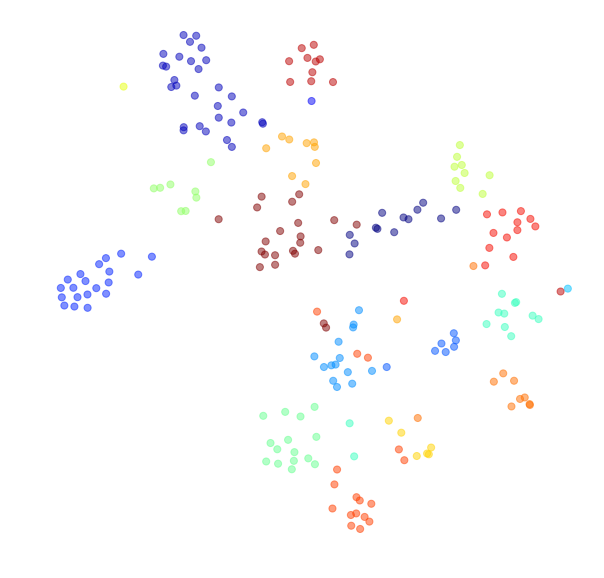

In [114]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.scatter(x[:,0], x[:,1], c=list(lookup_poinf_more_drop.best_topic), cmap=plt.cm.jet, s=50, alpha=.5)
ax.legend(loc='best')
ax.axis('off')
plt.show()

In [159]:
x.shape

(219, 2)

#### `MDS`

In [115]:
# Multidimensional Scaling
mds_poinf = manifold.MDS(n_components=2, random_state=rng).fit_transform(data_poinf)

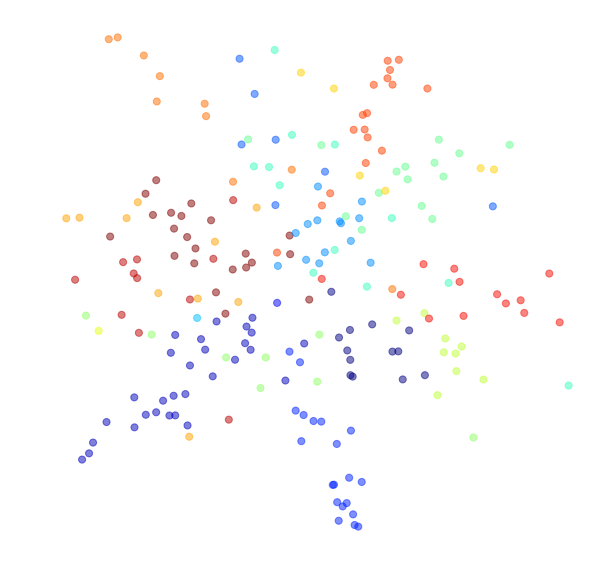

In [119]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.scatter(mds_poinf[:,0], mds_poinf[:,1], c=list(lookup_poinf_more_drop.best_topic), cmap=plt.cm.jet, s=50, alpha=.5)
ax.legend(loc='best')
ax.axis('off')
plt.show()

### K means

In [121]:
kmeansClustering = KMeans(n_clusters=20).fit_predict(data_poinf)

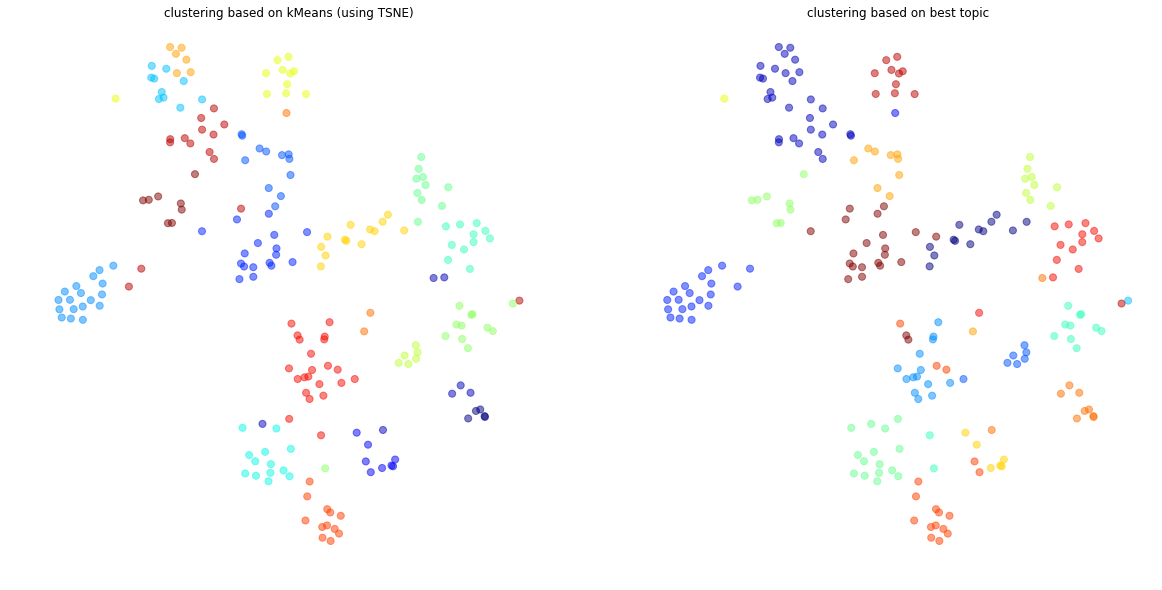

In [122]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(x[:,0], x[:,1], c=kmeansClustering, cmap=plt.cm.jet, s=50, alpha=.5)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('clustering based on kMeans (using TSNE)')
ax2 = f.add_subplot(122)
ax2.scatter(x[:,0], x[:,1], c=list(lookup_poinf_more_drop.best_topic), cmap=plt.cm.jet, s=50, alpha=.5)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('clustering based on best topic')
plt.show()

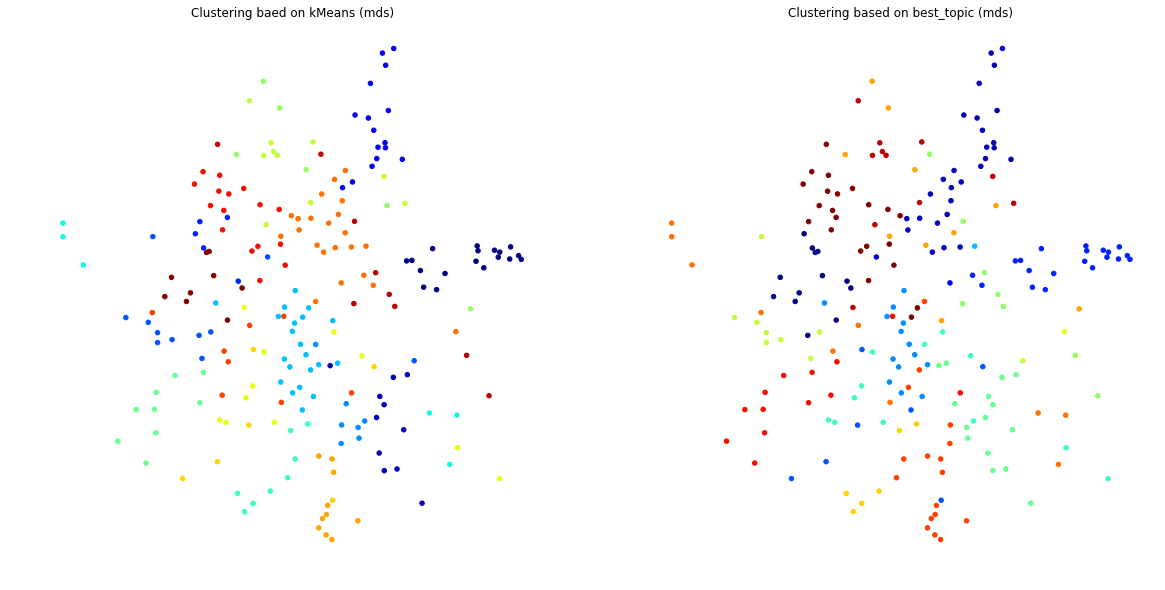

In [177]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax.scatter(mds_poinf[:,0], mds_poinf[:,1], c=kmeansClustering, cmap=plt.cm.jet, s=20)
ax.legend(loc='best')
ax.axis('off')
ax.set_title('Clustering baed on kMeans (mds)')

ax2 = f.add_subplot(122)
ax2.scatter(mds_poinf[:,0], mds_poinf[:,1], c=list(lookup_poinf_more_drop.best_topic), cmap=plt.cm.jet, s=20)
ax2.legend(loc='best')
ax2.axis('off')
ax2.set_title('Clustering based on best_topic (mds)')
plt.show()
plt.show()

### DBScan

In [178]:
from sklearn.cluster import DBSCAN

In [190]:
dbscan = DBSCAN(min_samples=1, algorithm='ball_tree', leaf_size=2).fit(data_poinf)

In [191]:
dbscan_clusters = dbscan.labels_
n_clusters_ = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
print 'number of clusters:', n_clusters_

In [193]:
dbscan_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [197]:
# Try with the tsne data:
dbscan_tsne = DBSCAN().fit(x)

In [198]:
dbscan_tsne_clusters = dbscan_tsne.labels_

In [199]:
n_clusters_tsne = len(set(dbscan_tsne_clusters)) - (1 if -1 in dbscan_tsne_clusters else 0)
print 'number of clusters:', n_clusters_

number of clusters: 1
